# Binance

- Créér un clé API : https://www.binance.com/en/support/faq/360002502072
- **Quand elle est créée garder en mémoire l'api key et la secret KEY**

- créer un fichier config.cfg dans le même répertoire que le notebook et remplacer les valeurs par celles de l'API créée

```cfg
[BINANCE]
API_KEY = YOUR KEY                  
SECRET_KEY = YOUR SECRET KEY        
```



- installer le package python-binance 

```shell
pip install python-binance
ou
py -m pip install python-binance
ou autre
```
- Editer la list my_coins avec vos crypto 
```python
#exemple
my_coins = ['BTC','USDT', 'ETH']     # A ADAPTER
```

- Editer le dict stack car l'API ne sait pas encore récupérer les crypto stackées 

```python
#exemple
stack = {'DOT':3, 'ADA':6.1938, 'CAKE':3.125, 'TRX': 67}      # A ADAPTER
```

- et lancer tout les cellules
! Tout est en dollars


(Il peut y avoir des erreurs de désynchronisation d'horloge. Pour corriger cliquer sur l'heure, puis "paramètre date et heure", puis "synchroniser maintenant")


#### LISTE A COMPLETER

In [33]:
import requests, json, time, hashlib,hmac, configparser
from binance import Client
# A ADAPTER 
my_coins = ['BTC', 'ETH', 'ADA', 'DOT', 'MATIC', 'KSM', 'CAKE', 'VET', 'SOL', 'BNB', 'LTC', 'THETA', 'AVAX', 'DENT', 'EGLD', 'HOT', 'TRX', 'ONE', 'BAND', 'SXP', 'LINK', 'UTK', 'USDT', 'BUSD']  
my_symbols = [coin + 'USDT' for coin in my_coins]

config = configparser.ConfigParser()
config.read_file(open('config.cfg'))

KEY = config.get('BINANCE', 'API_KEY')
SECRET_KEY = config.get('BINANCE', 'SECRET_KEY')
BASE_URL = 'https://api.binance.com/'

client = Client(KEY, SECRET_KEY)


In [34]:
from urllib.parse import urlencode

# fonctions utilitaires

def get_timestamp():
    return int(time.time() * 1000)

def hashing(query_string):
    return hmac.new(SECRET_KEY.encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256).hexdigest()

def dispatch_request(http_method):
    session = requests.Session()
    session.headers.update({
        'Content-Type': 'application/json;charset=utf-8',
        'X-MBX-APIKEY': KEY
    })
    return {
        'GET': session.get,
        'DELETE': session.delete,
        'PUT': session.put,
        'POST': session.post,
    }.get(http_method, 'GET')

def send_signed_request(http_method, url_path, payload={}):
    query_string = urlencode(payload, True)
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, get_timestamp())
    else:
        query_string = 'timestamp={}'.format(get_timestamp())

    url = BASE_URL + url_path + '?' + query_string + '&signature=' + hashing(query_string)
    print("{} {}".format(http_method, url))
    params = {'url': url, 'params': {}}
    response = dispatch_request(http_method)(**params)
    return response.json()


In [35]:
# Create wallet
def create_wallet():
    wallet = {}
    for asset in my_coins:
        wallet[asset] = {'Price':0, 'Current_market_price':0, 'Buy_price': 0, 'Qty':0, 'Saving_value':0, 'Spot_value':0, 'Stack_value':0, 'Balance':0, 'ATH': 0, 'ATH_percent':0, 'Buy_price_percent':0, 'earn':0}
    return wallet

In [36]:
# Get order history
def update_order_history(wallet):
    for symbol in my_symbols:
        
        if symbol != 'USDTUSDT' and symbol != 'BUSDUSDT':
            for i in range(3):
                orders_history = []
                while orders_history == [] :
                    orders_history = client.get_all_orders(symbol=symbol)
                sum_coin = 0.0
                sum_cost = 0.0
                sell_coin = 0.0
                sell_cost = 0.0
                for order in orders_history:
                    if order['side'] == 'BUY':
                        sum_cost += float(order['executedQty']) * float(order['price'])
                        sum_coin += float(order['executedQty']) 
                    elif order['side'] == 'SELL':
                        # sum_cost -= float(order['executedQty']) * float(order['price'])
                        # sum_coin -= float(order['executedQty']) 
                        sell_cost +=  float(order['executedQty']) * float(order['price'])
                        sell_coin += float(order['executedQty'])
                if sum_coin > wallet[symbol.replace('USDT', '')]['Qty']:
                    wallet[symbol.replace('USDT', '')]['Qty'] = sum_coin - sell_coin
                    wallet[symbol.replace('USDT', '')]['Buy_price'] = sum_cost / sum_coin
                    wallet[symbol.replace('USDT', '')]['Price'] =sum_cost - sell_cost
                    wallet[symbol.replace('USDT', '')]['earn'] = sell_cost

In [37]:
def update_market_price(wallet):
    all_coins = client.get_all_tickers()
    for asset in my_coins:
        if asset != 'USDT':
            for symbol in all_coins:
                if symbol['symbol'] == asset+'USDT':
                    wallet[asset]['Current_market_price'] = float(symbol['price'])

In [38]:
# Get current Savings
def update_saving(wallet):
    saving = send_signed_request('GET', 'sapi/v1/lending/union/account')
    savings = saving['positionAmountVos']
    for asset in savings:
        wallet[asset['asset']]["Saving_value"] = float(asset['amountInUSDT'])

In [39]:
# stop value
def update_spot(wallet):
    spot = send_signed_request('GET', 'api/v3/account')

    for asset in my_coins:
        for asset_spot in spot["balances"]:
            if asset_spot['asset'] == asset:
                if asset != "USDT":
                    wallet[asset]['Spot_value'] = wallet[asset]['Current_market_price'] * float(asset_spot['free'])
                else:
                    wallet[asset]['Spot_value'] = float(asset_spot['free'])

#### STACK A COMPLETER

In [40]:
# get stacking value
def update_stacking(wallet):    
    # A ADAPTER
    stack = {'ADA':17.2+6.247+18.94+7.992+14.5+8.02,  'KSM':0.1599+0.24, 'MATIC':65+139.7+18, 'VET':497 , 'CAKE':1.785+4.06, 'SOL':0.56+0.5, 'DOT':9.556 , 'ETH':0.068836, 'BNB': 0.09388}
    for asset in my_coins:
        try:
            coin = stack[asset]
            wallet[asset]['Stack_value'] = wallet[asset]['Current_market_price'] * coin
        except:
            pass

In [41]:
# balance calcul
def update_balance(wallet):
    for asset in my_coins:
        wallet[asset]["Balance"] =  wallet[asset]["Stack_value"] + wallet[asset]["Saving_value"] + wallet[asset]["Spot_value"] -  wallet[asset]["Price"] + wallet[asset]["earn"]

In [42]:
# Get ATH
def update_ath(wallet):
    for asset in my_coins:
        if asset != 'USDT':
            earliest_timestamp = client._get_earliest_valid_timestamp(asset + 'USDT', '1d')  # Here "ETHUSDT" is a trading pair and "1d" is time interval
            candle = client.get_historical_klines(asset + 'USDT', Client.KLINE_INTERVAL_1WEEK, "1 May, 2021")
            max_asset = 0
            for c in candle:
                if float(c[2]) > max_asset:
                    max_asset = float(c[2])
            wallet[asset]['ATH'] = max_asset
            wallet[asset]['ATH_percent'] = wallet[asset]['Current_market_price'] / wallet[asset]['ATH'] 

In [43]:
def update_buy_price_percent(wallet):
    for asset in my_coins:
        if wallet[asset]['Current_market_price'] != 0:
            wallet[asset]['Buy_price_percent'] = wallet[asset]['Buy_price']  / wallet[asset]['Current_market_price'] 

In [44]:
def main():
    wallet = create_wallet()
    update_market_price(wallet)
    update_order_history(wallet)
    update_ath(wallet)
    update_market_price(wallet)
    update_saving(wallet)
    update_spot(wallet)
    update_stacking(wallet)
    update_balance(wallet)
    update_buy_price_percent(wallet)
    with open("binance.json", "w") as outfile: 
        json.dump(wallet, outfile)
    return wallet

wallet = main()

GET https://api.binance.com/sapi/v1/lending/union/account?timestamp=1627923493778&signature=22b74c812118e1065cf75b8918d9452336c235026979724a98a08bc0e137a794
GET https://api.binance.com/api/v3/account?timestamp=1627923494097&signature=b40473e0a5d16bb4c6e824fcd569cd0b62d74c0518effadf827a12605d1bf761


In [45]:
import pandas as pd
pd.DataFrame.from_dict(wallet,  orient='index')

,Price,Current_market_price,Buy_price,Qty,Saving_value,Spot_value,Stack_value,Balance,ATH,ATH_percent,Buy_price_percent,earn
BTC,226.092220,39793.470000,38165.465901,0.005924,235.895084,0.000000,0.000000,9.802864,59500.000000,0.668429,0.959089,0.0000
ETH,191.958088,2647.170000,2374.837164,0.080830,32.017373,0.000000,182.220594,22.279879,4372.720000,0.604432,0.897123,0.0000
ADA,143.654880,1.330800,1.363985,105.320000,44.285030,0.000000,97.013989,-2.355861,2.470000,0.538259,1.024936,0.0000
DOT,217.063720,18.609000,20.674704,10.499000,19.867450,0.000000,177.827604,-19.368666,49.780000,0.373262,1.111006,0.0000
MATIC,312.526722,1.066250,1.427063,219.000000,0.712896,0.000000,237.453875,-74.359951,2.700000,0.394333,1.338394,0.0000
KSM,113.495750,209.500000,286.750253,0.395800,0.000000,0.084418,83.779050,-29.632282,625.000000,0.334800,1.368736,0.0000
CAKE,73.673400,16.111000,14.267858,5.726000,0.216815,0.000000,94.168795,73.951410,42.980000,0.374407,0.885597,53.2392
VET,55.757800,0.087340,0.112053,497.600000,0.000000,0.000000,43.407980,-12.349820,0.250000,0.349040,1.282957,0.0000
SOL,35.046424,33.690000,32.938368,1.064000,0.000000,19.017881,35.711400,19.682857,58.380000,0.575899,0.977690,0.0000
BNB,31.221760,335.330000,325.226667,0.096000,0.066470,0.000000,31.480780,0.325490,691.770000,0.484337,0.969870,0.0000


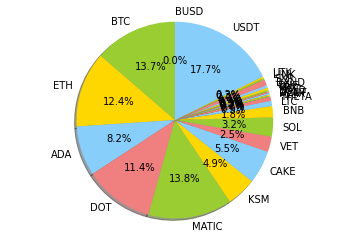

In [46]:
import matplotlib.pyplot as plt

labels = [asset for asset in my_coins]
sizes = [wallet[asset]['Spot_value'] + wallet[asset]['Saving_value'] + wallet[asset]['Stack_value'] for asset in  my_coins]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [47]:
## Bilan

# global balance
balance = 0
total_usdt_invest = 0
total_spot = 0
total_saving = 0
total_stacking = 0
current_value = 0

for asset in wallet:
    if asset != "USDT" and  asset != "BUSD":
        balance += wallet[asset]['Balance']
        total_usdt_invest +=  wallet[asset]['Price']
        total_spot += wallet[asset]['Spot_value']
        total_saving += wallet[asset]['Saving_value']
        total_stacking += wallet[asset]['Stack_value']
    else:
        total_usdt_invest +=wallet[asset]['Balance']
        total_spot += wallet[asset]['Spot_value']
        total_saving += wallet[asset]['Saving_value']
        total_stacking += wallet[asset]['Stack_value']

current_value = total_spot + total_saving + total_stacking

print('total_spot',total_spot,'$')
print('total_saving',total_saving,'$')
print('total_stacking',total_stacking,'$')
print('total_usdt_invest',total_usdt_invest,'$')
print('current_value',current_value,'$')
print('balance',balance,'$')
print('plus-value', current_value - (total_usdt_invest*current_value/current_value), '$')
print('plus-value percent', (current_value - (total_usdt_invest*current_value/current_value)) / total_usdt_invest * 100, '%')

total_spot 41.428644319200004 $
total_saving 703.39925014 $
total_stacking 983.0640677199999 $
total_usdt_invest 1890.0047362800003 $
current_value 1727.8919621792 $
balance -108.87357410079993 $
plus-value -162.11277410080038 $
plus-value percent -8.577373960441955 %


C:\Users\Thibaut - Eva\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  # This is added back by InteractiveShellApp.init_path()


<Figure size 720x720 with 0 Axes>

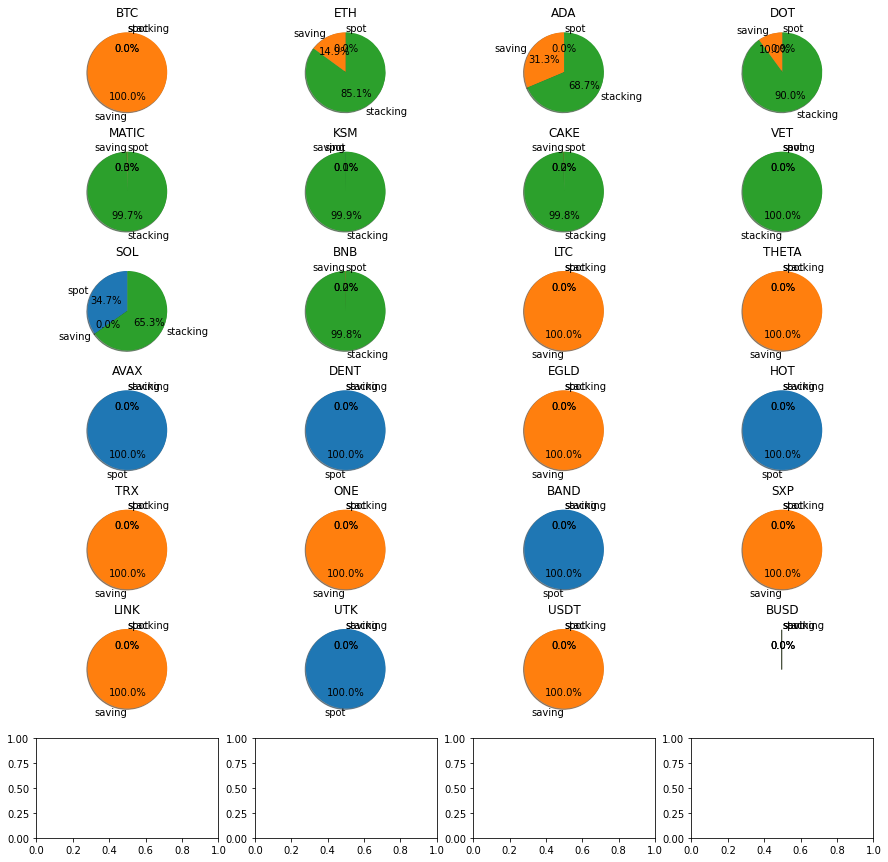

In [48]:
plt.figure(1, figsize=(10, 10))
chats_labels = my_coins
num_columns = 4                                
num_rows  = len(chats_labels) // 4 + 1
fig, ax = plt.subplots(num_rows,num_columns)
label = ['spot', 'saving', "stacking"]
for i, coin in enumerate(chats_labels):
    data = [wallet[coin]['Spot_value'], wallet[coin]['Saving_value'], wallet[coin]['Stack_value']]
    ax[i//4,i%4].set_title(coin)                           # Add 1 to j index
    ax[i//4,i%4].pie(data, labels=label,                 # Add 1 to j index
                autopct='%1.1f%%', shadow=True, startangle=90)
fig.set_size_inches(15,15)
plt.show()

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import IntProgress, widgets

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#FF4600'
c2='#3DD600' 

color = colorFader(c1,c2,mix=0.5)
for asset in my_coins:
    value=wallet[asset]['Current_market_price']
    maxi=wallet[asset]['ATH']
    color = colorFader(c1,c2,mix=wallet[asset]['ATH_percent'])
    
    display(widgets.FloatProgress(
        value=value,
        min=0,
        max=maxi,
        description=asset,
        bar_style='success',
        style={'bar_color': color},
        orientation='horizontal',
    readout=True,
    readout_format='.1f',
    disabled=False
    ))
    
    display(widgets.HTML(
    value = asset + ": "+str(wallet[asset]['Current_market_price']) + ' / '+ str(wallet[asset]['ATH'])
    ))


FloatProgress(value=39793.47, bar_style='success', description='BTC', max=59500.0, style=ProgressStyle(bar_col…

HTML(value='BTC: 39793.47 / 59500.0')

FloatProgress(value=2647.17, bar_style='success', description='ETH', max=4372.72, style=ProgressStyle(bar_colo…

HTML(value='ETH: 2647.17 / 4372.72')

FloatProgress(value=1.3308, bar_style='success', description='ADA', max=2.47, style=ProgressStyle(bar_color='#…

HTML(value='ADA: 1.3308 / 2.47')

FloatProgress(value=18.609, bar_style='success', description='DOT', max=49.78, style=ProgressStyle(bar_color='…

HTML(value='DOT: 18.609 / 49.78')

FloatProgress(value=1.06625, bar_style='success', description='MATIC', max=2.7, style=ProgressStyle(bar_color=…

HTML(value='MATIC: 1.06625 / 2.7')

FloatProgress(value=209.5, bar_style='success', description='KSM', max=625.0, style=ProgressStyle(bar_color='#…

HTML(value='KSM: 209.5 / 625.0')

FloatProgress(value=16.111, bar_style='success', description='CAKE', max=42.98, style=ProgressStyle(bar_color=…

HTML(value='CAKE: 16.111 / 42.98')

FloatProgress(value=0.08734, bar_style='success', description='VET', max=0.25, style=ProgressStyle(bar_color='…

HTML(value='VET: 0.08734 / 0.25')

FloatProgress(value=33.69, bar_style='success', description='SOL', max=58.38, style=ProgressStyle(bar_color='#…

HTML(value='SOL: 33.69 / 58.38')

FloatProgress(value=335.33, bar_style='success', description='BNB', max=691.77, style=ProgressStyle(bar_color=…

HTML(value='BNB: 335.33 / 691.77')

FloatProgress(value=143.95, bar_style='success', description='LTC', max=413.49, style=ProgressStyle(bar_color=…

HTML(value='LTC: 143.95 / 413.49')

FloatProgress(value=5.9, bar_style='success', description='THETA', max=13.2, style=ProgressStyle(bar_color='#a…

HTML(value='THETA: 5.9 / 13.2')

FloatProgress(value=13.289, bar_style='success', description='AVAX', max=43.885, style=ProgressStyle(bar_color…

HTML(value='AVAX: 13.289 / 43.885')

FloatProgress(value=0.0024786, bar_style='success', description='DENT', max=0.011699, style=ProgressStyle(bar_…

HTML(value='DENT: 0.0024786 / 0.011699')

FloatProgress(value=95.47, bar_style='success', description='EGLD', max=205.0, style=ProgressStyle(bar_color='…

HTML(value='EGLD: 95.47 / 205.0')

FloatProgress(value=0.006338, bar_style='success', description='HOT', max=0.01684, style=ProgressStyle(bar_col…

HTML(value='HOT: 0.006338 / 0.01684')

FloatProgress(value=0.06534, bar_style='success', description='TRX', max=0.17, style=ProgressStyle(bar_color='…

HTML(value='TRX: 0.06534 / 0.17')

FloatProgress(value=0.07877, bar_style='success', description='ONE', max=0.18858, style=ProgressStyle(bar_colo…

HTML(value='ONE: 0.07877 / 0.18858')

FloatProgress(value=6.371, bar_style='success', description='BAND', max=20.673, style=ProgressStyle(bar_color=…

HTML(value='BAND: 6.371 / 20.673')

FloatProgress(value=2.275, bar_style='success', description='SXP', max=5.87, style=ProgressStyle(bar_color='#b…

HTML(value='SXP: 2.275 / 5.87')

FloatProgress(value=23.127, bar_style='success', description='LINK', max=53.0, style=ProgressStyle(bar_color='…

HTML(value='LINK: 23.127 / 53.0')

FloatProgress(value=0.2353, bar_style='success', description='UTK', max=1.065, style=ProgressStyle(bar_color='…

HTML(value='UTK: 0.2353 / 1.065')

FloatProgress(value=0.0, bar_style='success', description='USDT', max=0.0, style=ProgressStyle(bar_color='#ff4…

HTML(value='USDT: 0 / 0')

FloatProgress(value=0.9998, bar_style='success', description='BUSD', max=1.0029, style=ProgressStyle(bar_color…

HTML(value='BUSD: 0.9998 / 1.0029')